
# 🚲 Bike Sharing — Proyek Analisis Data
**Kelas:** Dicoding — Proyek Analisis Data  
**Dataset:** UCI Bike Sharing (`day.csv`, `hour.csv`)

## Identitas
- **Nama:** Farhan Iqratama  
- **Email:** farhniqratama@gmail.com  
- **ID Dicoding:** farhan_iqratama

Notebook ini mengikuti template resmi: **Gathering → Assessing → Cleaning → EDA → Visualization → Conclusion**.

## Menentukan Pertanyaan Bisnis
1. **Kapan (jam & hari) permintaan sewa sepeda mencapai puncak, dan bagaimana polanya antar musim?**  
2. **Faktor apa yang paling berkorelasi dengan total penyewaan (`cnt`) pada data harian?**


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
%matplotlib inline



## Data Wrangling — Gathering Data
Memuat dataset **`data/day.csv`** dan **`data/hour.csv`**, serta menambahkan kolom nama musim agar mudah dibaca.


In [2]:

# Load data
day = pd.read_csv("data/day.csv")
hour = pd.read_csv("data/hour.csv")

# Tambah nama musim
season_map = {1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"}
day['season_name'] = day['season'].map(season_map)
hour['season_name'] = hour['season'].map(season_map)

day.head(), hour.head()


(   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
 0        1  2011-01-01       1   0     1        0        6           0   
 1        2  2011-01-02       1   0     1        0        0           0   
 2        3  2011-01-03       1   0     1        0        1           1   
 3        4  2011-01-04       1   0     1        0        2           1   
 4        5  2011-01-05       1   0     1        0        3           1   
 
    weathersit      temp     atemp       hum  windspeed  casual  registered  \
 0           2  0.344167  0.363625  0.805833   0.160446     331         654   
 1           2  0.363478  0.353739  0.696087   0.248539     131         670   
 2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
 3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
 4           1  0.226957  0.229270  0.436957   0.186900      82        1518   
 
     cnt season_name  
 0   985      Spring  
 1   801      Spring  
 2 


**Insight (Gathering):**
- Dataset harian (`day`) dan per jam (`hour`) berhasil dimuat.
- Ditambahkan kolom **`season_name`** agar analisis musiman lebih mudah.



## Data Wrangling — Assessing Data
Cek jumlah baris, *missing values*, dan *duplicates* pada kedua dataset.


In [3]:

day_info = {
    "rows": len(day),
    "missing": int(day.isna().sum().sum()),
    "duplicates": int(day.duplicated().sum())
}
hour_info = {
    "rows": len(hour),
    "missing": int(hour.isna().sum().sum()),
    "duplicates": int(hour.duplicated().sum())
}
day_info, hour_info


({'rows': 731, 'missing': 0, 'duplicates': 0},
 {'rows': 17379, 'missing': 0, 'duplicates': 0})


**Insight (Assessing):**
- Tidak ditemukan *missing values* maupun *duplicate* pada kedua dataset.
- Data siap untuk proses *cleaning* (sederhana) dan EDA.



## Data Wrangling — Cleaning Data
Karena tidak ada missing/duplikasi, *cleaning* bersifat defensif (drop duplicates jika ada) dan standarisasi kolom pendukung visualisasi.


In [4]:

# Drop duplikasi (jaga-jaga)
day = day.drop_duplicates()
hour = hour.drop_duplicates()

# Tambahkan nama hari agar visualisasi lebih mudah dipahami
weekday_map = {0:"Sun", 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat"}
if "weekday_name" not in day.columns and "weekday" in day.columns:
    day["weekday_name"] = day["weekday"].map(weekday_map)

# Atur urutan kategori agar konsisten
order_days = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
season_order = ["Spring", "Summer", "Fall", "Winter"]
if "weekday_name" in day.columns:
    day["weekday_name"] = pd.Categorical(day["weekday_name"], categories=order_days, ordered=True)
day["season_name"]  = pd.Categorical(day["season_name"],  categories=season_order, ordered=True)
hour["season_name"] = pd.Categorical(hour["season_name"], categories=season_order, ordered=True)

# Salin ke variabel *_clean* (sesuai template)
day_clean = day.copy()
hour_clean = hour.copy()

day_clean.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_name,weekday_name
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,Spring,Sat
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,Spring,Sun
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,Spring,Mon
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,Spring,Tue
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,Spring,Wed



**Insight (Cleaning):**
- Data tetap bersih (tidak ada yang dibuang).
- Menambahkan `weekday_name` & mengatur urutan kategori (Sun→Sat, Spring→Winter) untuk konsistensi visualisasi.



## Exploratory Data Analysis (EDA)

### Pertanyaan 1  
**Kapan (jam & hari) permintaan sewa sepeda mencapai puncak, dan bagaimana polanya antar musim?**


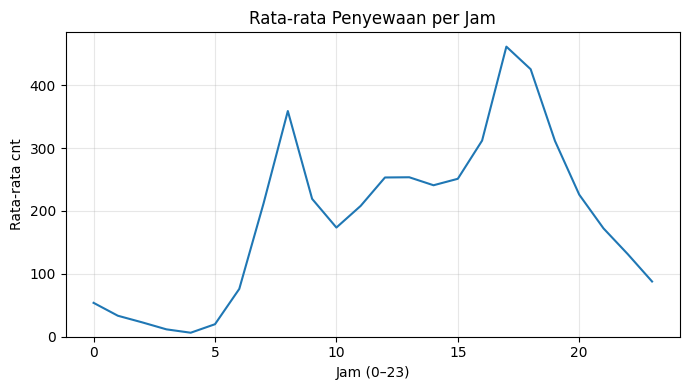

In [5]:

# --- Pola rata-rata per jam ---
fig, ax = plt.subplots(figsize=(7,4))
hourly = (hour_clean.groupby('hr', as_index=False)['cnt']
          .mean().sort_values('hr'))
ax.plot(hourly['hr'], hourly['cnt'])
ax.set_title("Rata-rata Penyewaan per Jam")
ax.set_xlabel("Jam (0–23)")
ax.set_ylabel("Rata-rata cnt")
ax.set_ylim(bottom=0)   # integritas visual
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



**Insight (Hourly):** Puncak permintaan terjadi pada jam **commute**: **07–09** (pagi) dan **17–19** (sore).


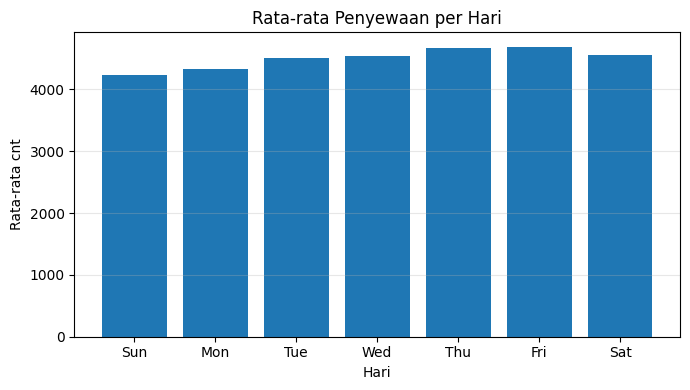

In [6]:

# --- Rata-rata per hari (weekday) ---
byweekday = (day_clean.groupby('weekday_name', as_index=False, observed=False)['cnt']
             .mean())

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(byweekday['weekday_name'], byweekday['cnt'])
ax.set_title("Rata-rata Penyewaan per Hari")
ax.set_xlabel("Hari")
ax.set_ylabel("Rata-rata cnt")
ax.set_ylim(bottom=0)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



**Insight (Weekday):** Hari kerja (**Mon–Fri**) cenderung lebih tinggi daripada akhir pekan (**Sat–Sun**).


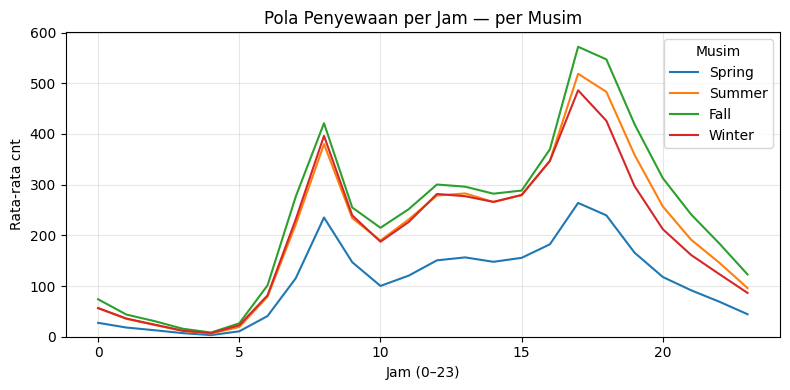

In [7]:

# --- Pola per jam per musim ---
byseason_hour = (hour_clean
                 .groupby(['season_name','hr'], as_index=False, observed=False)['cnt']
                 .mean()
                 .sort_values(['season_name','hr']))

fig, ax = plt.subplots(figsize=(8,4))
for s, g in byseason_hour.groupby('season_name', observed=False):
    ax.plot(g['hr'], g['cnt'], label=str(s))
ax.set_title("Pola Penyewaan per Jam — per Musim")
ax.set_xlabel("Jam (0–23)")
ax.set_ylabel("Rata-rata cnt")
ax.set_ylim(bottom=0)
ax.grid(True, alpha=0.3)
ax.legend(title="Musim")
plt.tight_layout()
plt.show()



**Insight (Season):** **Summer** rata-rata penyewaan tertinggi; **Winter** terendah. Puncak jam commute konsisten di semua musim, namun **besarnya berbeda**.



## Visualization & Explanatory Analysis

### Pertanyaan 2  
**Faktor apa yang paling berkorelasi dengan total penyewaan (`cnt`) pada data harian?**


In [8]:

corr_cols = ['temp','atemp','hum','windspeed','casual','registered','cnt']
corr = day_clean[corr_cols].corr(numeric_only=True)
corr['cnt'].sort_values(ascending=False)


cnt           1.000000
registered    0.945517
casual        0.672804
atemp         0.631066
temp          0.627494
hum          -0.100659
windspeed    -0.234545
Name: cnt, dtype: float64


**Insight (Correlation):**
- **`registered`** memiliki korelasi tertinggi dengan **`cnt`**.
- **`temp/atemp`** berkorelasi positif (cuaca hangat → peningkatan permintaan).
- **`hum`** cenderung negatif; **`windspeed`** lemah/negatif.



## Conclusion

- **Kesimpulan Pertanyaan 1:**  
  Permintaan tertinggi terjadi pada jam **commute** (07–09 & 17–19) dan lebih tinggi pada **hari kerja**; **Summer** memiliki permintaan tertinggi secara musiman.

- **Kesimpulan Pertanyaan 2:**  
  **Registered** adalah indikator terkuat terhadap total penyewaan `cnt`. **Suhu** berpengaruh positif, **kelembapan** cenderung menekan.

**Rekomendasi Operasional:**
1. Prioritaskan ketersediaan sepeda pada jam puncak (pagi & sore), terutama di **Summer**.  
2. Pertimbangkan promosi/penyesuaian harga saat cuaca hangat.  
3. Monitor cuaca ekstrem (angin/kelembapan) untuk optimasi penjadwalan.
